<a href="https://colab.research.google.com/github/phoenixfin/plantdisesase_cnn/blob/master/notebook/Plant_Disease_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing

## Import some modules

In [0]:
import tensorflow as tf
import numpy as np
import os, random
from google.colab import drive
from matplotlib import pyplot as plt

## Set up kaggle datasets

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Before run the following code, please create first API Token in your Kaggle account (go to the `My Account` section on profile. Then click on `Create New API Token`). You will obtain ‘kaggle.json’ file. This file has the credentials of your API token for your account. Upload this to your google drive and set the path to `json_path` variable below.

In following block, follow a link given, give access to Google Drive and enter a verification code for the API to work.

In [0]:
drive.mount('/content/gdrive')
json_path = "Colab Notebooks/misc/"

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/"+json_path

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Download the datasets

In [0]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.68G/2.70G [00:31<00:00, 90.7MB/s]
100% 2.70G/2.70G [00:31<00:00, 91.5MB/s]


Unzip the downloaded file and remove the zip file

In [0]:
!unzip \*.zip  && rm *.zip

# Set up Model Framework

Just run the following block to define the base framework class for the nerual network to be used 

In [0]:
class BaseConvolutionalNetwork(object):
    callbacks_list = [
        'no_progresss_stopping', 
        'save_per_epoch', 
        'log_to_csv', 
        'good_result_stopping'
    ]    
    
    hyperparam = {}
    augmentation = {}
    
    def __init__(self, load=False):
        if not load:
            self.create_new()
        else:
            self.load(load)

    def show_summary(self):
        self.model.summary()

    def load(self,filename, obj='model'):
        if obj=='model':
            self.model = tf.keras.models.load_model('saved/'+filename)
        elif obj=='weights_only':
            self.model.load_weights('saved/'+filename+'/variables')
        else:
            print('Load failed. Unknown mode')

    def save(self, filename, obj='model'):
        path = 'saved/'+filename
        if obj=='model':
            self.model.save(path)
        elif obj=='weights_only':
            self.model.save_weights(path+'/'+variables)
        else:
            print('Load failed. Unknown mode')        

    def reset_model(self, mode='metrics_only'):
        if mode=='model':
            self.create_new()
        elif mode=='metrics_only':
            self.model.reset_metrics()
        else:
            print('Load failed. Unknown mode')

    def create_new(self):
        self.model = tf.keras.models.Sequential()        
    
    def add_convolution(self, filter_num, kernels_size, 
                        pooling = (2,2), activation = 'relu', 
                        dropout = 0, normalize = False, first = True):
        kwargs = {'activation':activation}
        input_ = self.hyperparam['input_shape']
        for i, num in enumerate(filter_num):
            kwargs['filters'] = num
            kwargs['kernel_size'] = kernels_size[i]
            if first and i==0: kwargs['input_shape']= input_ + (3,)

            self.model.add(tf.keras.layers.Conv2D(**kwargs))

            if pooling: 
                self.model.add(tf.keras.layers.MaxPooling2D(*pooling))
            if normalize:
                self.model.add(tf.keras.layers.BatchNormalization())

        if dropout:
            self.model.add(tf.keras.layers.Dropout(dropout))

        self.model.add(tf.keras.layers.Flatten())
        
    def set_hidden_layers(self, neurons_list, dropout = 0, 
                          normalize = False, activation='relu'):
        for num in neurons_list:
            hidden = tf.keras.layers.Dense(num, activation=activation)           
            self.model.add(hidden)
            if dropout:
                self.model.add(tf.keras.layers.Dropout(dropout))
            if normalize:
                self.model.add(tf.keras.layers.BatchNormalization())

    def set_output_layer(self):              
        if self.mode == 'binary':
            activation = 'sigmoid'
            out_neurons = 1
        elif self.mode == 'categorical':
            activation = 'softmax'
            out_neurons = self.image_data['train'].num_classes

        output = tf.keras.layers.Dense(out_neurons, activation=activation)
        self.model.add(output)

    def set_parameters(self, dict_p):
        self.hyperparam = dict_p
        
    def set_augmentations(self, aug_dict):
        self.augmentation = aug_dict

    def obtain_image_data(self, path):
        train_dir = path+'/train'
        val_dir = path+'/valid'
                
        IMG = tf.keras.preprocessing.image.ImageDataGenerator
        # tg = IMG(**self.augmentation)
        tg = IMG(rescale = 1.0/255.)
        vg = IMG(rescale = 1.0/255.)

        classes = len(os.listdir(train_dir))
        self.mode = 'binary' if classes == 2 else 'categorical'

        train_data = tg.flow_from_directory(
            train_dir,
            batch_size = self.hyperparam['batch_size'],
            class_mode = self.mode,
            target_size = self.hyperparam['input_shape']
        )
        validation_data =  vg.flow_from_directory(
            val_dir,
            batch_size = self.hyperparam['batch_size'],
            class_mode = self.mode,
            target_size = self.hyperparam['input_shape']
        )
        self.image_data = {'train':train_data, 'val':validation_data}

    def set_callbacks(self, cb_list):
        callbacks = []
        CB = tf.keras.callbacks

        # no progress stopping callback
        if 'no_progress_stopping' in cb_list:
            impatient = CB.EarlyStopping(monitor='accuracy', patience=3)
            callbacks.append(impatient)

        # save per epoch callback
        if 'save_per_epoch' in cb_list:
            checkpoint_save = CB.ModelCheckpoint(
                filepath="saved", 
                save_best_only=True)
            callbacks.append(checkpoint_save)

        # log to csv file callback
        if 'log_to_csv' in cb_list:
            logger = CB.CSVLogger('log.csv')
            callbacks.append(logger)

        # stop when enough callback
        if 'good_result_stopping' in cb_list:
            def stopper(epoch, logs):
                if logs['accuracy']>0.97: self.model.stop_training = True
            good_res = CB.LambdaCallback(on_epoch_end=lambda e,l: stopper(e,l))
            callbacks.append(good_res)
                            
        return callbacks

    def train(self, save=False):
        p = self.hyperparam
        
        # Compile the model
        opt = tf.keras.optimizers.Adam(learning_rate=p['learning_rate'])
        loss = self.mode + '_crossentropy'
        self.model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

        # Set some callbacks
        cb_list = self.callbacks_list.copy()
        if not save:
            cb_list.remove('save_per_epoch')
        callbacks = self.set_callbacks(cb_list)

        # Fitting the data!
        history = self.model.fit(
            self.image_data['train'],
            validation_data = self.image_data['val'],
            steps_per_epoch = p['steps'],
            epochs = p['epoch'],
            validation_steps = p['val_steps'],
            callbacks = callbacks
        )
        return history
     
    def predict(self, test_path, num):
        IM = tf.keras.preprocessing.image
        class_dict = self.image_data['train'].class_indices
        test_data = os.listdir(test_path)
        randomized = random.sample(test_data, num)

        for file in randomized:
            img = IM.load_img(test_path+'/'+file, 
                              target_size = self.hyperparam['input_shape'])

            x = IM.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])
            res = self.model.predict(images, batch_size=10)

            print(file, ': ',class_dict.keys()[np.argmax(res[0])])

Set up some basic hyperparameters and other augmentation parameters. The commented code shows the default available augmentation we can adjust.

In [0]:
# ====== Default Augmentation ===========
# 'featurewise_center'              : False, 
# 'samplewise_center'               : False,
# 'featurewise_std_normalization'   : False, 
# 'samplewise_std_normalization'    : False,
# 'zca_whitening'                   : False, 
# 'zca_epsilon'                     : 1e-06, 
# 'rotation_range'                  : 0, 
# 'width_shift_range'               : 0.0,
# 'height_shift_range'              : 0.0, 
# 'brightness_range'                : None, 
# 'shear_range'                     : 0.0, 
# 'zoom_range'                      : 0.0,
# 'channel_shift_range'             : 0.0, 
# 'fill_mode'                       : 'nearest', 
# 'cval'                            : 0.0, 
# 'horizontal_flip'                 : False,
# 'vertical_flip'                   : False, 
# 'rescale'                         : None, 
# 'preprocessing_function'          : None,
# 'data_format'                     : None, 
# 'validation_split'                : 0.0, 
# 'dtype'                           : None        


augmentation = {
    'rescale'             : 1./255,
    'rotation_range'      : 40,
    'width_shift_range'   : 0.2,
    'height_shift_range'  : 0.2,
    'shear_range'         : 0.2,
    'zoom_range'          : 0.2,
    'horizontal_flip'     : True,
}

hyperparam = {
    'batch_size'    : 32, 
    'epoch'         : 20,
    'steps'         : 100,
    'val_steps'     : 80,
    'learning_rate' : 0.001,   
    'input_shape'   : (300, 300)
}


data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'


Set up the data path. Please make sure inside the directory, there are `train` and `valid` folders, which each contains class directories containing images data.  

In [0]:
cnn = BaseConvolutionalNetwork()

cnn.set_augmentations(augmentation)
cnn.set_parameters(hyperparam)

cnn.obtain_image_data(data_path)

cnn.add_convolution([64, 64, 128,128], [(3,3)]*4)
cnn.set_hidden_layers([512])
cnn.set_output_layer()

cnn.show_summary()

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
________________________________

In [0]:
history = cnn.train(save=True)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 3.2653 - accuracy: 0.1300WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved/assets
100/100 [==============================] - 1025s 10s/step - loss: 3.2653 - accuracy: 0.1300 - val_loss: 2.6511 - val_accuracy: 0.2590
Epoch 2/20
100/100 [==============================] - 1011s 10s/step - loss: 2.2908 - accuracy: 0.3494 - val_loss: 1.9666 - val_accuracy: 0.4219
Epoch 3/20
100/100 [==============================] - 960s 10s/step - loss: 1.8175 - accuracy: 0.4725 - val_loss: 1.8986 - val_accuracy: 0.4328
Epoch 4/20
100/100 [==============================] - 972s 10s/step - loss: 1

In [0]:
def plot_accuracy(history):
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

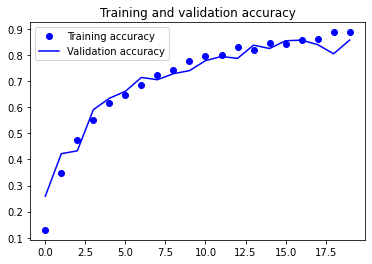

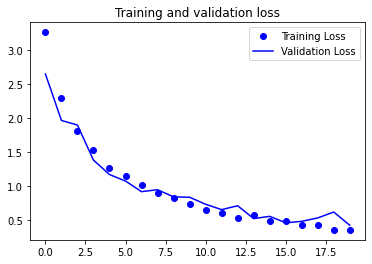

In [0]:
plot_accuracy(history)

In [0]:
cnn.predict('/content/test/test', 20)